In [1]:
#import paper_plots as carlosplt
from pymongo import MongoClient
import stat_tests as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import vendors.debian.DLAmine as dla
import json
import csv
from matplotlib.font_manager import FontProperties
import seaborn as sns
import laplace_tests as lptests
import statsmodels.api as sm

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
class Plotter:
    def __init__(self, src2month, pkg_with_cvss, years):
        self.src2month = src2month
        self.pkg_with_cvss = pkg_with_cvss
        self.years = years
        self.src2month_temp = dict()
        self.src2month_loc = dict()
        self.l=self.m=self.h=self.udef=0

    def plot_severity_percentage(self):
        num_low = [0] * (self.years+1)
        num_med = [0] * (self.years+1)
        num_high = [0] * (self.years+1)
        num_udef = [0] * (self.years+1)
        total = [0] * (self.years+1)
        for i in self.pkg_with_cvss:
            for j in range(len(self.src2month[i])):
                try:
                    num_low[j//12] += self.pkg_with_cvss[i][j][0]
                    num_med[j//12] += self.pkg_with_cvss[i][j][1]
                    num_high[j//12] += self.pkg_with_cvss[i][j][2]
                    num_udef[j//12] += self.pkg_with_cvss[i][j][3]
                    total[j//12] += self.pkg_with_cvss[i][j][3] + self.pkg_with_cvss[i][j][2] + self.pkg_with_cvss[i][j][1] + self.pkg_with_cvss[i][j][0]
                except IndexError:
                    xx = j//12
                    if xx==19:
                        continue
                    else:
                        raise IndexError('List index out of bounds')
        ## Generate percentage
        for i in range(self.years + 1):
            try:
                num_low[i] = num_low[i]/total[i]
                num_med[i] = num_med[i]/total[i]
                num_high[i] = num_high[i]/total[i]
                num_udef[i] = num_udef[i]/total[i]
            except ZeroDivisionError:
                num_low[i] = 0
                num_med[i] = 0
                num_high[i] = 0
                num_udef[i] = 0

        print(num_low)
        print(num_high)


        #carlosplt.pre_paper_plot()        

        pal = ['#fee8c8', '#fdbb84', '#e34a33', 'grey']
        x = range(2001, 2001 + self.years)

        labels_cvss = ['low', 'medium', 'high', 'N/A']

        h = plt.stackplot(x, [num_low[1:], num_med[1:], num_high[1:], num_udef[1:]], colors = pal, alpha=0.9, labels = labels_cvss)
        plt.xticks(x)
        plt.legend(loc='upper left', handles = h[::-1])
        #carlosplt.post_paper_plot(True,True,True)
        plt.show()

    
    ## Plot sum of vulnerabilities. Can filter out by severity using the booleans low, med, high, undefined
    def plot_all_severity(self, l, m, h, udef):
        #carlosplt.pre_paper_plot()
        self.l = l
        self.m = m
        self.h = h
        self.udef = udef
        for i in self.pkg_with_cvss:
            self.src2month_temp[i]=[]
            for j in range(len(self.src2month[i])):
                num_low = self.pkg_with_cvss[i][j][0]
                num_med = self.pkg_with_cvss[i][j][1]
                num_high = self.pkg_with_cvss[i][j][2]
                num_udef = self.pkg_with_cvss[i][j][3]
                tempp = 0
                if l:
                    tempp += num_low
                if m:
                    tempp += num_med
                if h:
                    tempp += num_high
                if udef:
                    tempp += num_udef
                self.src2month_temp[i].append(tempp)

        for i in self.src2month:
            self.src2month_loc[i]=self.src2month_temp[i][:] # don't cut data for 2018

        self.severityPlotter = Temp_Plotter(self)
        self.severityPlotter.plot_total()

        # Plot total number per year
        self.pkgnumPlotter = NumPackages_Plotter(self.severityPlotter)
        
        # Plot number of affected packages per year
        self.pkgnumPlotter.plot_num_affected()
        
        # Plot average number of vulnerabilities per affected package per year
        self.pkgnumPlotter.plot_average_number()

        # Plot regular and LTS for Wheezy
        self.wheezy = WheezyPloter(self)
        self.wheezy.plot_wheezy_lts()

In [3]:
class Temp_Plotter:
    def __init__(self, plotter):
        self.src2month = plotter.src2month
        self.pkg_with_cvss = plotter.pkg_with_cvss
        self.years = plotter.years
        self.src2month_loc = plotter.src2month_loc

        self.src2sum = dict()
        self.src2year = dict()
        self.src2lastyears = dict()
        self.src2dens = dict()
        self.src2month_temp = dict()
        self.year_sum = []
        self.year_num = []

    def plot_total(self):
        self.year_sum = [0] * self.years
        self.year_num = [0] * self.years
        for pkg in self.src2month_loc:
            for j in range(self.years):
                temp =  sum(self.src2month_loc[pkg][12*(1+j):12*(2+j)])
                if (temp>0):
                    self.year_num[j] += 1
                self.year_sum[j] += temp 
            ## For last 2 years
            total = sum(self.src2month_loc[pkg][:])
            last_years = sum(self.src2month_loc[pkg][-24:])
            #print(pkg + '; ' + str(last_years))
            if (total>1):
                self.src2sum[pkg] = total
                self.src2lastyears[pkg] = last_years
        
        #calc total
        sum_total = 0
        one_only=0
        one_plus=0
        for p in self.src2month:
            sum_part = sum(self.src2month_loc[p][:])
            sum_total += sum_part
            if (sum_part == 1):
                one_only += 1
            elif (sum_part>1):
                one_plus += 1

        print('Total = ', sum_total)
        print('one_only = ', one_only)
        print('one_plus = ', one_plus)

        values = sorted(self.src2sum.values(),reverse=True)
        #print(values)
        keys = list(sorted(self.src2sum, key=self.src2sum.__getitem__, reverse=True))

        n = len(self.year_sum)
        yearsx = []
        for i in range(1,self.years+1):
            if i%2==1:
                yearsx.append('\''+str(i).zfill(2))
            else:
                yearsx.append('')
        x = range(self.years)

        width = 1/2
        plt.bar(x, self.year_sum, width, color='darkblue', edgecolor='black')
        #plt.bar(x, average_per_year, width)
        plt.xticks(np.arange(0,n),yearsx)
        plt.ylabel('Total vulnerabilities')
        plt.xlabel('Year')
        #carlosplt.post_paper_plot(True,True,True)
        
        sum_all = sum(values)
        print("Total: ", sum_all)

        ## Linear regression model
        X = sm.add_constant(x)
        y = self.year_sum
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        plt.plot(predictions)
        plt.show()
        print(model.summary())
        #print(model.summary().as_latex())

In [4]:
class NumPackages_Plotter:
    def __init__(self, plotter):
        self.plotter = plotter
        self.yearsx = []

    def plot_num_affected(self):
        ## Number of affected packages
        n = len(self.plotter.year_sum)
        for i in range(1,self.plotter.years+1):
            if i%2==1:
                self.yearsx.append('\''+str(i).zfill(2))
            else:
                self.yearsx.append('')
        x = range(self.plotter.years)
        width = 1/2
        plt.bar(x, self.plotter.year_num, width, color='darkblue', edgecolor='black')
        plt.xticks(np.arange(0,n),self.yearsx)
        plt.ylabel('Number of affected packages')
        plt.xlabel('Year')
        #carlosplt.post_paper_plot(True,True,True)
        plt.show()

    def plot_average_number(self):
        average_per_year = [0] * self.plotter.years
        for j in range(self.plotter.years):
            average_per_year[j] = self.plotter.year_sum[j]/float(self.plotter.year_num[j])
        
        x_values = list(range(1,self.plotter.years+1))
        slope = np.polyfit(x_values,average_per_year,1)
        
        print('Slope: ' + str(slope))
        
        n = len(self.plotter.year_sum)
        x = range(self.plotter.years)
        width = 1/2
        #plt.bar(x, year_sum, width)
        plt.bar(x, average_per_year, width, color='darkblue', edgecolor='black')
        plt.xticks(np.arange(0,n),self.yearsx)
        plt.ylabel('Average vulnerabilities per package')
        plt.xlabel('Year')
        #carlosplt.post_paper_plot(True,True,True)
        ## Linear regression
        X = sm.add_constant(x)
        y = average_per_year
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        plt.plot(predictions)
        plt.show()
        print(model.summary())
        #print(model.summary().as_latex())

In [5]:
class WheezyPloter:
    def __init__(self, plotter):
        self.plotter = plotter
        self.yearsx = []
        self.l = plotter.l
        self.m = plotter.m
        self.h = plotter.h
        self.udef = plotter.udef


    def plot_wheezy_lts(self):
        quarter_num = self.plotter.years*4
        # Get LTS and plot
        try:
            with open("DLA_sum.txt","rb") as fp:
                ltslist = pickle.load(fp)
            with open("src2month_DLA.txt","rb") as fp:
                src2monthDLAs = pickle.load(fp)
            with open("DLA_src2month.json","r") as fp:
                src2monthDLA = json.load(fp)
            with open("DLA_withcvss.json","r") as fp:
                self.src2monthDLA_cvss = json.load(fp)
                # Fix this so it can compute when required
                #dla.permonthDLA(src2monthDLAs)
            with open("1000.csv","r") as csvfile:
                spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

        except IOError:
            ltslist = dla.getDLAs()
            with open("src2month_DLA.txt","rb") as fp:
                src2monthDLAs = pickle.load(fp)
            dla.permonthDLA(src2monthDLAs)
            return self.plot_wheezy_lts()
        
        ## Plot for wheezy
        quarter_sum = [0] * quarter_num

        DLA_temp=dict()
        
        ## Fix src2monthDLA_cvss
        for i in self.src2monthDLA_cvss:
            temp_list = []
            for j in self.src2monthDLA_cvss[i]:
                temp_list += j
            self.src2monthDLA_cvss[i] = temp_list

        ## Fix ltslist according to severity
        for i in self.src2monthDLA_cvss:
            DLA_temp[i]=[]
            for j in range(len(self.src2monthDLA_cvss[i])):
                num_low = self.src2monthDLA_cvss[i][j][0]
                num_med = self.src2monthDLA_cvss[i][j][1]
                num_high = self.src2monthDLA_cvss[i][j][2]
                num_udef = self.src2monthDLA_cvss[i][j][3]
                tempp = 0
                if self.l:
                    tempp += num_low
                if self.m:
                    tempp += num_med
                if self.h:
                    tempp += num_high
                if self.udef:
                    tempp += num_udef
                DLA_temp[i].append(tempp)

        
        ltslist = []

        for m in range((self.plotter.years+1)*12):
            s = 0
            #print(m)
            for i in DLA_temp:
                s += DLA_temp[i][m]
            ltslist.append(s)


        totalLTS = ltslist
        plt.bar([i for i in range(len(ltslist))],ltslist)
        plt.show()

        quartersx = []
        for i in range(1,self.plotter.years+1):
            for j in range(1,5):
                if j==1:
                    quartersx.append('Q' + str(j)+'\''+str(i).zfill(2))
                else:
                    quartersx.append(' ')
    
        for pkg in self.plotter.src2month_loc:
            for j in range(quarter_num):
                temp =  sum(self.plotter.src2month_loc[pkg][12+(3*j):12+3*(j+1)])
                quarter_sum[j] += temp 

        LTS_quarter = []
    
        for j in range(quarter_num):
            temp = sum(totalLTS[12+(3*j):12+3*(j+1)])
            LTS_quarter.append(temp)

        ## Print all LTS
        cut = 12*4+1
        n = len(quarter_sum)
        x = range(quarter_num)
        width = 1/2

        plt.bar(x, LTS_quarter, width, color='brown', label='regular support', edgecolor='black')
    
        plt.xticks(np.arange(0,n),quartersx, rotation="vertical")
        plt.ylabel('Vulnerabilities per quarter of Debian LTS')
        plt.xlabel('Quarter')
        #carlosplt.post_paper_plot(True,True,True)
        plt.show()
    
        ## Filter only wheezy:
        quarter_sum_regular = [0] * (12*4+1) + quarter_sum[12*4+1:12*4+9] + [0] * 12
        quarter_sum_errors = [0] * (12*4 + 9) + quarter_sum[12*4+9:12*4+9+5] + [0] * 7
        LTS_quarter = [0] * (15*4+2) + LTS_quarter[15*4+2:-3]
        
        whole_w = quarter_sum_regular[:-12] + quarter_sum_errors[12*4+9:-7] + LTS_quarter[15*4+2:]
    
        #print(quarter_sum_errors)
        cut = 12*4+1
        n = len(quarter_sum) - cut
        x = range(quarter_num-cut-3)
        width = 1/2
        
        #print(len(LTS_quarter))
        print(len(x))
        print(len(quarter_sum_regular[cut:]))
        print(len(quarter_sum_errors[cut:]))
        bar1 = plt.bar(x, quarter_sum_regular[cut:], width, color='darkblue', label='regular', edgecolor='black')
        bar12 = plt.bar(x, quarter_sum_errors[cut:], width, color='darkorange', label='regular*', edgecolor='black')
        bar2 = plt.bar(x, LTS_quarter[cut:], width, color='darkred', label ='long-term', edgecolor='black')
        plt.legend(handles=[bar1, bar12, bar2])
    
        plt.xticks(np.arange(0,n),quartersx[cut:], rotation="vertical")
        plt.ylabel('Vulnerabilities per quarter')
        plt.xlabel('Quarter')
        #carlosplt.post_paper_plot(True,True,True)
        ## Linear Regression
        print(len(x))
        print(len(whole_w[cut:]))
        X = sm.add_constant(x)
        y = whole_w[cut:]
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        plt.plot(predictions)
        plt.show()
        print(model.summary())
        #print(model.summary().as_latex())

In [6]:
def plot_all(src2month, pkg_with_cvss):
    years = 18
    # 2001-2000+years

    myplotter = Plotter(src2month, pkg_with_cvss, years)
    
    # consider severity (low, medium, high, undefined)
    # Undefined is usual for newly added packages
    myplotter.plot_all_severity(True,True,True,True)
    myplotter.plot_severity_percentage()

In [7]:
with open('./vendors/debian/cache/src2dsa') as fp:
    src2dsa=json.load(fp)
with open('./vendors/debian/cache/dsa2cve') as fp:
    dsa2cve=json.load(fp)
with open('./vendors/debian/cache/src2month') as fp:
    src2month=json.load(fp)
with open('./vendors/debian/cache/pkg_with_cvss') as fp:
    pkg_with_cvss=json.load(fp)

In [10]:
print(len(src2month['linux']))

240


In [ ]:
single_src2month=dict()
single_pkg_with_cvss=dict()

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Total =  12786
one_only =  604
one_plus =  700
Total:  12182


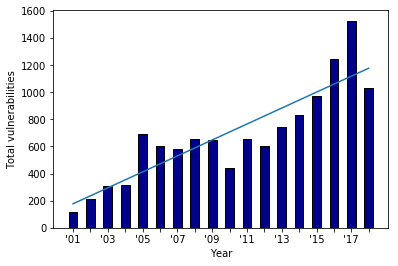

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     54.29
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           1.59e-06
Time:                        09:03:56   Log-Likelihood:                -117.53
No. Observations:                  18   AIC:                             239.1
Df Residuals:                      16   BIC:                             240.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.1345     79.542      2.227      0.0

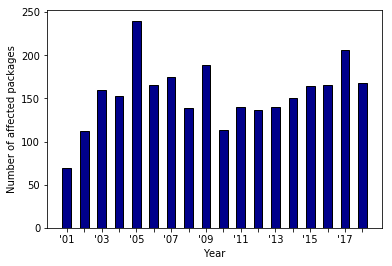

Slope: [0.32739844 1.14054064]


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


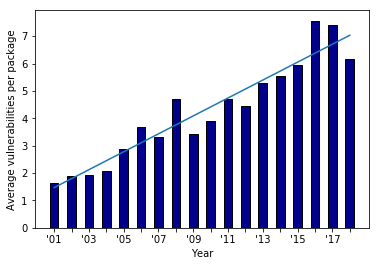

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     156.9
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           1.10e-09
Time:                        09:03:56   Log-Likelihood:                -14.532
No. Observations:                  18   AIC:                             33.06
Df Residuals:                      16   BIC:                             34.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4679      0.260      5.639      0.0

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


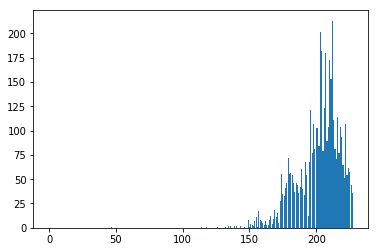

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


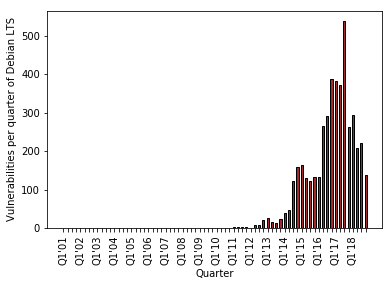

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


20
20
20
20
20


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


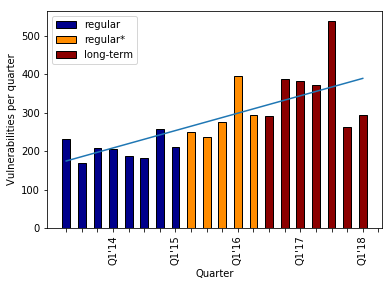

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     19.59
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           0.000326
Time:                        09:03:58   Log-Likelihood:                -111.10
No. Observations:                  20   AIC:                             226.2
Df Residuals:                      18   BIC:                             228.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.5571     28.413      6.144      0.0

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


[0, 0.21238938053097345, 0.06635071090047394, 0.08116883116883117, 0.13249211356466878, 0.1509433962264151, 0.09390444810543658, 0.054982817869415807, 0.03816793893129771, 0.03709428129829984, 0.10657596371882086, 0.08662613981762918, 0.09586776859504133, 0.09838274932614555, 0.08763505402160865, 0.07384615384615385, 0.06169871794871795, 0.05431937172774869, 0.05705996131528046]
[0, 0.4690265486725664, 0.5023696682464455, 0.4837662337662338, 0.45425867507886436, 0.39477503628447025, 0.3673805601317957, 0.34536082474226804, 0.4534351145038168, 0.43431221020092736, 0.3356009070294785, 0.378419452887538, 0.32892561983471075, 0.3086253369272237, 0.31932773109243695, 0.3415384615384615, 0.2219551282051282, 0.29450261780104714, 0.18375241779497098]


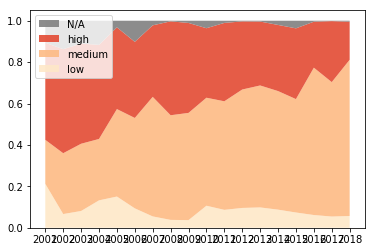

In [8]:
plot_all(src2month, pkg_with_cvss)